In [6]:
# # BCM Rule - recurrent network
import sys
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.signal as sig
get_ipython().magic('matplotlib inline')

ImportError: No module named 'cPickle'

In [3]:
class NeuralNet(object):
    
    def __init__(self, GROUPS_NUM=5, FF_NUM=200, REC_EXC_NUM=100, REC_INH_NUM=100, 
                 TOT_TIME=20, STEPS_DIM=0.0001,  TIME_CONST = 0.01,
                 TARGET_RATE=20, STARTING_RATE = 20, MEAN_DRIVE = 10,
                 THETA_START=0.07, ETA_E=float('1e-6'), ETA_I=float('1e-4'), TAU=1,
                 FF_PL=False, REC_PL_E=False, REC_PL_I=False):
        
        #self.GROUPS_NUM = GROUPS_NUM
            
        self.FF_NUM = FF_NUM
        self.REC_EXC_NUM = REC_EXC_NUM
        self.REC_INH_NUM = REC_INH_NUM
        self.REC_NUM = REC_EXC_NUM + REC_INH_NUM        
        self.TOT_TIME = TOT_TIME
        self.STEPS_DIM = STEPS_DIM
        self.STARTING_RATE = STARTING_RATE #starting rate for recurrent network
        self.TARGET_RATE = TARGET_RATE
        self.THETA_START = THETA_START
        self.ETA_E = ETA_E
        self.ETA_I = ETA_I
        self.TAU = TAU #for weights
        self.FF_PL = FF_PL
        self.REC_PL_E = REC_PL_E
        self.REC_PL_I = REC_PL_I
        self.TIME_CONST = TIME_CONST #for rate
        self.MEAN_DRIVE = MEAN_DRIVE
        
        self.SUB_SAMP = 2000
        
        self.change_values()
        self.set_ff_activation()
        
        
    def __repr__(self):
        return '''%d FF neurons\n%d REC neurons''' % (self.FF_NUM, self.REC_NUM) 
        
        
    def change_values(self):
        
        self.STEPS_N = round(self.TOT_TIME/self.STEPS_DIM) # time steps = total simulation time / simulation step size
        self.time_vect = np.linspace(0,self.TOT_TIME, self.STEPS_N) # create a time vector of size TOT.time and step size 
        
        self.rec_nn = np.zeros((self.REC_NUM, self.STEPS_N)) # create empty array with size of the recurrent network
        self.rec_nn[:,0] = np.random.randint(0,self.STARTING_RATE,self.REC_NUM) # intial firing rates at time step 0
        
        self.ff_nn = np.zeros((self.REC_NUM, self.STEPS_N))
        
        # create a random weight matrix for feed-forward input (size REC x FF) 
        self.w_ff = np.eye(self.REC_NUM)
        
        self.w_ff[self.REC_EXC_NUM:,self.REC_EXC_NUM:] = 0 #no feedforward input for inhibitory neurons! 
        
        # create a random weight matrix for the recurrent network
        
        #Draw recurrent weights from gamma distribution
        R = 0.1 #Limit radius for eigenvalues in complex space
        K = 2 #shape of the Gamma distribution
        THETA = R/((2*self.REC_NUM)**(1/2.0))

        w_rec = np.random.gamma(K, THETA, [self.REC_NUM,self.REC_NUM])
        np.fill_diagonal(w_rec,0)
        scal = np.absolute(sum(w_rec[:,:self.REC_EXC_NUM].T)/sum(w_rec[:,self.REC_EXC_NUM:].T))        
        w_rec[:,self.REC_EXC_NUM:] = -(w_rec[:,self.REC_EXC_NUM:] * scal.reshape((-1,1))) #inhibitory 
        
#        w_rec[:,self.REC_EXC_NUM:] = -3*w_rec[:,self.REC_EXC_NUM:] #inhibition 3x excitation
        
        self.w_rec = w_rec

        self.w_history = np.zeros((
                self.REC_NUM, self.REC_NUM, round(self.STEPS_N/self.SUB_SAMP-1)))
        
        self.theta = np.zeros((self.REC_NUM, self.STEPS_N))
        self.theta[:,0] = self.THETA_START
        
        #targ = np.ones((self.REC_NUM))*self.TARGET_RATE
        #self.mean_drive = targ - self.w_rec.dot(targ)
    
    def set_ff_activation(self, BACKGROUND_TYPE='none', #BACKGROUND_VALUE=None, 
                          STIM_VALUE=1, STIM_TYPE='none', CORR_IN_GROUP=0.5,#STIM_LENGTH=None, #STIM_END=None,
                          GROUPS_NUM=5, make_uncorr=False):
                        #target_neurons=[]):
        
        if STIM_VALUE is None:
            STIM_VALUE = self.STARTING_RATE/4
        
        #Set the background (input values to nonstimulated neurons - zero or random noise)
        if BACKGROUND_TYPE=='none':
            #Set the input values of the non stimulated neurons
            noise = np.zeros((self.REC_NUM, self.STEPS_N)) 
            
        elif BACKGROUND_TYPE=='random':
            #Set the input values of the non stimulated neurons
            noise = np.random.rand(
                self.REC_NUM, self.time_vect.shape[0])*NOISE_VALUE 
            
        elif BACKGROUND_TYPE=='OU_noise':
            sigma_mtx = corr_mtx_4_ou(N=self.FF_NUM, VAR=STIM_VALUE, GROUPS_NUM=GROUPS_NUM, 
                  CORR_IN_GROUP=CORR_IN_GROUP, make_uncorr=make_uncorr, ei_clustering=False)
            
            noise = ou_process(sigma_mtx, self.STEPS_N, STEPS_DIM=self.STEPS_DIM)
            
            plt.imshow(sigma_mtx)
        
        elif BACKGROUND_TYPE=='OU_noise_ei_clustering':
            sigma_mtx = corr_mtx_4_ou(N=self.FF_NUM, VAR=STIM_VALUE, GROUPS_NUM=GROUPS_NUM, 
                  CORR_IN_GROUP=CORR_IN_GROUP, make_uncorr=make_uncorr, ei_clustering=True)
                
            plt.imshow(sigma_mtx)
            
            noise = ou_process(sigma_mtx, self.STEPS_N, STEPS_DIM=self.STEPS_DIM)
            
        self.ff_nn = noise

        
    def display_stim(self):
        f, ax = plt.subplots(1,1, figsize = (20,5))
        ax.imshow(self.ff_nn, aspect='auto',  interpolation='nearest')
        plt.colorbar
        
    
    def run_network(self):
        
        #  rec.nn                           --> recurrent network 
        #  STEPS_DIM/TIME_CONST             --> size of simulation interval / rate time constant
        #  self.rec_nn                     --> leaky term 
        #  w_rec dot rec_nn                --> matrix multiplication of recurrent weight matrix and recurrent 
        #  w_ff dot ff_nn                  --> feed-forward weight matrix * feed-forward input firing rates
        #self.w_history[:,:,0] = self.w_rec
        k=0
        
        for i in range(1,self.STEPS_N):
            self.rec_nn[:,i] = self.rec_nn[:,i-1] + (self.STEPS_DIM/self.TIME_CONST)*(
                    -self.rec_nn[:,i-1] + io_function(self.w_rec[:,:].dot(self.rec_nn[:,i-1]) + 
                    self.w_ff[:,:].dot(self.ff_nn[:,i-1]) + self.MEAN_DRIVE))
            
            # BCM threshold theta
            # TAU --> BCM time constant

            
            # recurrent network placticiy
            # ETA --> factor of the BCM rule

            if i%500 == 0 and i > (5*self.TAU/self.STEPS_DIM):
                if self.REC_PL_E:
                    self.w_rec[:,:self.REC_EXC_NUM] = self.w_rec[:,:self.REC_EXC_NUM] + self.ETA_E*np.outer(
                        (self.rec_nn[:,i-1]*(self.rec_nn[:,i-1] - self.theta[:,i-1])), 
                        (self.rec_nn[:self.REC_EXC_NUM,i-1]))
                    
                if self.REC_PL_I:
                    self.w_rec[:,self.REC_EXC_NUM:] = self.w_rec[:,self.REC_EXC_NUM:] - self.ETA_I*np.outer(
                        (self.rec_nn[:,i-1] - self.TARGET_RATE), 
                        self.rec_nn[self.REC_EXC_NUM:,i-1])
                    
                if self.FF_PL:                
                    self.w_ff = self.w_ff + self.ETA *(
                        (self.rec_nn[:,i-1]*(self.rec_nn[:,i-1] - self.theta[:,i-1])) * self.ff_nn[:,i-1].T)

                
                np.fill_diagonal(self.w_rec[:,:], 0) # set diagonal to 0 to prevent self-excitation
                

            self.w_rec[:,:self.REC_EXC_NUM] = np.clip(self.w_rec[:,:self.REC_EXC_NUM], 0, np.inf)
            self.w_rec[:,self.REC_EXC_NUM:] = np.clip(self.w_rec[:,self.REC_EXC_NUM:], -np.inf,0)
                
            self.theta[:,i] = self.theta[:,i-1] + (self.STEPS_DIM/self.TAU) * (
                -self.theta[:,i-1] + (self.rec_nn[:,i]**2)/self.TARGET_RATE)
            
            if i%self.SUB_SAMP == 0:
                self.w_history[:,:,k] = self.w_rec[:,:]
                k+=1
            
        self.w_history[:,:,-1] = self.w_rec
            
                                
    def plot_rate(self):
        f, ax = plt.subplots(1,2, figsize = (20,5))

        img1 = ax[0].imshow(self.rec_nn[:,::1000], aspect='auto', interpolation = 'nearest')
        ax[0].set_title('change in network firing rate over time')
        plt.colorbar(img1, ax=ax[0])
        
        ax[1].plot(np.mean(self.rec_nn[:,:],0)) #mean rate over time over network 
        ax[1].set_title('mean change in rate of whole network over simulation')
        
    
    def plot_weight(self):
        f, ax = plt.subplots(1,2, figsize = (20,5))
        ax[0].set_title('change in weights of subset of exc and inh neurons over simulation')
        img1 = ax[0].pcolor(self.w_sample[:,::100], vmin=-4, vmax=4)
        plt.colorbar(img1, ax=ax[0])
        #plt.show()
        
        img2 = ax[1].imshow(self.w_history[:,:,0], interpolation='nearest')
        ax[1].set_title('weight matrix at beginning of the simulation')
        plt.colorbar(img2, ax=ax[1])


def corr_mtx_4_ou(N, VAR=1, GROUPS_NUM=1, CORR_IN_GROUP=0.5,
                   make_uncorr=False, ei_clustering=False):
    
    POS_CORR = CORR_IN_GROUP #positive correlation for inputs on covariance matrix
    GROUP_SIZE = int(N/GROUPS_NUM) #number of neurons in each group 

    #Calculate the negative correlation to have 0.001 sum over the rows
    if ei_clustering:
        GROUP_SIZE = round(GROUP_SIZE/2)
        NEG_CORR = -(0.999 + (GROUP_SIZE-1)*POS_CORR)/((GROUPS_NUM-1)*GROUP_SIZE)
        block = POS_CORR*np.ones([GROUP_SIZE, GROUP_SIZE])
        sigma_mtx = np.kron(np.eye(GROUPS_NUM), block) #block diagonal 
        sigma_noise = np.kron(np.ones((2,2)), sigma_mtx)
        
        np.fill_diagonal(sigma_noise, 1.001)
    else:
        NEG_CORR = -(0.999 + (GROUP_SIZE-1)*POS_CORR)/((GROUPS_NUM-1)*GROUP_SIZE)
        block = POS_CORR*np.ones([GROUP_SIZE, GROUP_SIZE])
        sigma_noise = np.kron(np.eye(GROUPS_NUM), block) #block diagonal 
        np.fill_diagonal(sigma_noise, 1)

    if not make_uncorr:
        sigma_noise[sigma_noise == 0] = NEG_CORR #fill everything else with -ve correlations 
    
    sigma_noise *= VAR    
    
    return sigma_noise

def ou_process(cov_mtx, STEPS_N, TAU=0.5, STEPS_DIM=0.0001):
    N = cov_mtx.shape[0]
    ell_noise = np.linalg.cholesky(cov_mtx)
    z_noise = np.sqrt(2*STEPS_DIM/TAU)

    noise = np.zeros((N,STEPS_N))
    noise[:,0] = ell_noise.dot(np.random.normal(0,1,(N)))
    
    for i in range(1,STEPS_N):
        noise[:,i] = (1 - STEPS_DIM/TAU)*noise[:,i-1] + z_noise*ell_noise.dot(np.random.normal(0,1,N))
    return noise

def io_function(x):
    #Nonlinear function that rectifies under 0
    x[x<0] = 0
    x[x>=20] = 20+80*np.tanh((x[x>=20]-20)/80)

    return x

In [ ]:
net = NeuralNet(GROUPS_NUM = 1, FF_NUM = 200, REC_EXC_NUM = 100, REC_INH_NUM = 100, 
                TOT_TIME = 3000, STEPS_DIM = 0.001, TIME_CONST = 0.01, 
                TARGET_RATE = 20, STARTING_RATE = 10, MEAN_DRIVE = 10,
                THETA_START = 0.1, ETA_E = float('1e-7'), ETA_I = float('1e-6'), TAU = 1, 
                FF_PL = False, REC_PL_E = True, REC_PL_I = True)

net.set_ff_activation(BACKGROUND_TYPE='OU_noise',  
                          STIM_VALUE=5, STIM_TYPE='none', CORR_IN_GROUP=0.8,
                          GROUPS_NUM=200, make_uncorr=True)

In [ ]:
net.run_network()

In [ ]:
f, ax = plt.subplots(1,2, figsize = (20,5))

img1 = ax[0].imshow(net.rec_nn[:,::10000], aspect='auto', interpolation = 'nearest')
ax[0].set_title('change in network firing rate over time')
plt.colorbar(img1, ax=ax[0])

#ax[1].plot(np.mean(net.rec_nn[:,:],0)) #mean rate over time over network 
ax[1].plot(net.rec_nn[1,::10000]) #mean rate over time over network 

ax[1].set_title('mean change in rate of whole network over simulation')
#ax[1].set_xlim(0,100)
plt.show()

In [ ]:
plt.imshow(net.w_rec)
plt.colorbar()
plt.show()

In [ ]:
diff_weight = (net.w_history[:,:,-1]-net.w_history[:,:,0])
plt.imshow(diff_weight[:,:], interpolation='nearest')
plt.colorbar()
plt.title('difference between first and last weight matrix')
plt.show()

In [ ]:
exc_str = net.w_history[:,:,0]
exc_end = net.w_history[:,:,-1]
diff_exc_weight = (exc_end-exc_str)/(exc_str+0.000000001)
diff_exc_weight[diff_exc_weight>0.70] = 0.7

plt.imshow(diff_exc_weight, interpolation='nearest')
plt.colorbar()
plt.title('Normalized difference')
plt.show()

In [ ]:
cov_in = np.cov(net.ff_n[:net.REC_EXC_NUM,:net.REC_EXC_NUM])

In [ ]:
plt.imshow(cov_in)

In [ ]:
ex_hist = net.w_history[:net.REC_EXC_NUM,:net.REC_EXC_NUM]
w_trend = np.reshape(ex_hist,(ex_hist.shape[0]*ex_hist.shape[1], ex_hist.shape[2]) )

In [ ]:
w_derivative = np.absolute(w_trend[:,:-1]-w_trend[:,1:])

In [ ]:
plt.plot(np.mean(w_trend,0))

In [ ]:
#plt.imshow(w_trend, aspect='auto')
for i in range(100):
    plt.plot(net.w_history[i,:]-net.w_history[i,1])
#plt.xlim([0,30])
plt.show()

In [ ]:
np.max(np.max(net.w_history[:,:,-1],0))

In [ ]:
fin_weights = net.w_history[:,:,-1]
fin_weights[fin_weights>(2/3)*np.max(np.max(net.w_history[:,:,-1],0))

In [ ]:
disp_weights = exc_end
low_lim = 0.01
up_lim = 0.02
disp_weights[disp_weights<low_lim] = low_lim
disp_weights[disp_weights>up_lim] = up_lim
plt.imshow(disp_weights)
plt.colorbar()
plt.plot()

In [ ]:
exc_weights = net.w_history[:,:,-1]
thr = 2/3
#exc_weights = exc_weights[:net.REC_EXC_NUM,:net.REC_EXC_NUM]
exc_diff = np.zeros(exc_weights.shape)
exc_diff[exc_weights>(thr*np.max(exc_weights))] = 1
exc_diff[exc_weights<(thr*np.max(exc_weights))] = 0
overlap = (exc_diff == exc_diff.T) * exc_diff
bidirectional_connections = np.argwhere(exc_diff != 0)
plt.imshow(exc_diff, interpolation = 'nearest', cmap='hot')
plt.title('\n strong (>2/3 max weight) bidirectional connections \n')

In [ ]:
bidirectional_weights = net.w_history[:,:,-1]

In [ ]:
np.savetxt('nocorr_exc_PL_inh_newPL_bidirectional_connections.txt', bidirectional_weights)

## Calculate lyapunov

In [ ]:
bdw = np.loadtxt('exc_PL_inh_newPL_bidirectional_connections.txt')
lyapunov_input = bdw

def calc_lyap(bdw)

    identity_mat = np.eye(net.REC_EXC_NUM)
    A = lyapunov_input - identity_mat
    Eij = sp.linalg.solve_lyapunov(A, 2*identity_mat)
    Cij = np.corrcoef(Eij)
    return Cij

plt.imshow(Cij, interpolation = 'nearest')

In [ ]:
#f = plt.figure(figsize=(20,10))
plt.imshow(net.ff_nn[:,::2000],  interpolation = 'nearest', aspect='auto')
plt.title('Input in time')
plt.colorbar()
plt.show()

## Run protocol 

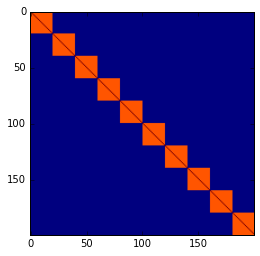

In [4]:
w_hist_list = []
activity_list = []

# ===== 1 =====
# 20 min, exc plasticity, correlated input

#Initialize network - only ex plasticity, 40 min, no input to I neurons
net = NeuralNet(FF_NUM = 200, REC_EXC_NUM = 100, REC_INH_NUM = 100, 
                TOT_TIME = 1200, STEPS_DIM = 0.001, TIME_CONST = 0.01, 
                TARGET_RATE = 20, STARTING_RATE = 10, 
                THETA_START = 0.1, ETA_E = float('1e-7'), ETA_I = float('1e-6'), TAU = 1, 
                FF_PL = False, REC_PL_E = True, REC_PL_I = True)

#Initialize correlated input
net.set_ff_activation(BACKGROUND_TYPE='OU_noise',  
                          STIM_VALUE=5, STIM_TYPE='none', CORR_IN_GROUP=0.8,
                          GROUPS_NUM=10, make_uncorr=False)

#run network and save connections and downsampled activity and w_history
net.run_network()
w_hist_list.append(net.w_history[:,:,::10]) 
activity_list.append(net.rec_nn[:,::100])
print('RAN: 20 min, exc plasticity, correlated input')


In [ ]:

# ===== 2 =====
#20 min, no plasticity, initial weights, uncorr input

#get previous initial weigths:
net.w_rec = w_hist_list[0][:,:,0]

#Switch off plasticity:
net.REC_PL_E = False

#set new uncorrelated input:
net.set_ff_activation(BACKGROUND_TYPE='OU_noise',  
                          STIM_VALUE=5, STIM_TYPE='none', CORR_IN_GROUP=0.8,
                          GROUPS_NUM=200, make_uncorr=True)

#run network and save connections and downsampled activity and w_history
net.run_network()
w_hist_list.append(net.w_history[:,:,::10])
activity_list.append(net.rec_nn[:,::10])
print('RAN: 20 min, no plasticity, initial weights, uncorr input')

In [12]:

# ===== 3 =====
#20 min, no plasticity, final weights, uncorr input (same as above)

#get previous final weigths:
net.w_rec = w_hist_list[0][:,:,-1] #is this the right index?? 

#run network and save connections and downsampled activity and w_history
net.run_network()
w_hist_list.append(net.w_history[:,:,::10])
activity_list.append(net.rec_nn[:,::10])
print('RAN: 20 min, no plasticity, final weights, uncorr input (same as above)')

In [ ]:

# ===== 4 =====
#20 min, plasticity, final weights, uncorr input (same as above)
net.REC_PL_E = True

#run network and save connections and downsampled activity and w_history
net.run_network()
w_hist_list.append(net.w_history[:,:,::10])
activity_list.append(net.rec_nn[:,::100])

print('RAN: 20 min, plasticity, final weights, uncorr input (same as above)')

In [7]:
np.save("whistlist.npy", w_hist_list)

In [19]:
len(w_hist_list)

3